# Explore the reference network


- [Crossref](https://www.crossref.org/) provides an API to get the references of a publication ([rest-api-doc](https://github.com/CrossRef/rest-api-doc)).


- The idea is to go down the references network for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 


## To do:
- resolve identical label
- stats:  n ref vs n citation, review vs foundational
- coloring: disconnected component for the 1st generation references, authors based cluster 
- interactive flask app


## With more data:
- use 'store' from scopus manual export + [query ref resolver](https://www.crossref.org/labs/resolving-citations-we-dont-need-no-stinkin-parser/)

- get country/city/univ  get flag/favicon





In [1]:
import crossrefexp as exp

In [2]:
store = exp.MetaDataStore('data/metadata_cache01.pickle')

default pickle location set to data/metadata_cache01.pickle


In [3]:
# Query metadata on Crossref
store.query(['10.1063/1.3284082', '10.1063/1.3284086','10.1063/1.3284083' ])

metadata for 10.1063/1.3284082 retrieved from Crossref in 1.875195 s.
metadata for 10.1063/1.3284086 retrieved from Crossref in 0.721202 s.
metadata for 10.1063/1.3284083 retrieved from Crossref in 0.718919 s.
data/metadata_cache01.pickle saved.


growth achieved - 49 nodes in the graph. The last generation number is 1.
metadata for 10.1021/jp801781s retrieved from Crossref in 1.824571 s.
metadata for 10.1103/PhysRevA.68.014103 retrieved from Crossref in 0.875121 s.
metadata for 10.1103/PhysRevB.57.9780 retrieved from Crossref in 2.016423 s.
metadata for 10.1016/S0038-1098(01)00288-5 retrieved from Crossref in 6.845903 s.
metadata for 10.1063/1.1774272 retrieved from Crossref in 0.819898 s.
metadata for 10.1016/S0040-6090(98)00429-5 retrieved from Crossref in 0.796292 s.
metadata for 10.1063/1.114701 retrieved from Crossref in 0.790059 s.
metadata for 10.1063/1.116681 retrieved from Crossref in 0.935447 s.
metadata for 10.1038/35044012 retrieved from Crossref in 1.751392 s.
metadata for 10.1063/1.331336 retrieved from Crossref in 0.787138 s.
metadata for 10.1126/science.282.5393.1429 retrieved from Crossref in 0.755035 s.
metadata for 10.1557/jmr.2008.0358 retrieved from Crossref in 0.836607 s.
metadata for 10.1103/PhysRevB.44.1

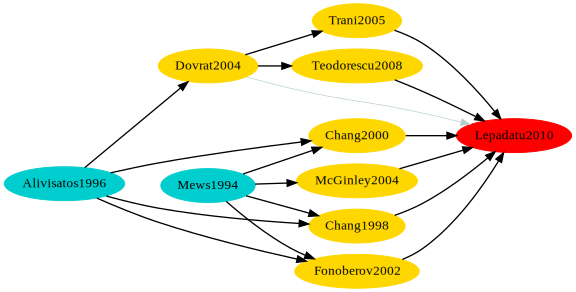

In [4]:
# Build the graph and everything:
gr = store.get_refgraphviz( '10.1063/1.3284083', gen=2, top=2 )
gr

In [5]:
# List of the top cited refs.
gr = store.build_a_refgraph( '10.1063/1.3284083', gen=2 )
print('-- Top cited: --')
for doi, citedby_count in gr.most_cited()[:10]:
    metadata = store.get(doi)
    print( '{}\t cited {} times [gen{}]  {}'.format(metadata.label(),
                                                   citedby_count, 
                                                   gr[doi]['gen'],
                                                   metadata.get('URL')) )

growth achieved - 49 nodes in the graph. The last generation number is 1.
growth achieved - 686 nodes in the graph. The last generation number is 2.
-- Top cited: --
Alivisatos1996	 cited 4 times [gen2]  http://dx.doi.org/10.1126/science.271.5251.933
Mews1994	 cited 4 times [gen2]  http://dx.doi.org/10.1021/j100054a032
30265	 cited 4 times [gen2]  None
16821	 cited 3 times [gen2]  None
Dovrat2004	 cited 3 times [gen1]  http://dx.doi.org/10.1103/physrevb.69.155311
60065	 cited 3 times [gen2]  None
22706	 cited 3 times [gen2]  None
34011	 cited 3 times [gen2]  None
74752	 cited 3 times [gen2]  None
18571	 cited 3 times [gen2]  None
